In [66]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

import torch
import faiss
from transformers import BlipModel

from blip_cbm import LitBlipCBM
from dataset import LitAwA2DM

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

Load weights from CBM

In [3]:
clipcbm_path = './lightning_logs/AwA2_CBM/blip_alpha0_relu/checkpoints/last.ckpt'
clipcbm = LitBlipCBM.load_checkpoint_as_model(clipcbm_path)

with torch.no_grad():
    concept_cavs = clipcbm.linear.weight.numpy()
concept_cavs.shape

/home/andrewbai/miniconda3/envs/hf/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:255: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['loss_c.pos_weight', 'loss_y.weight']
  rank_zero_warn(


(85, 443136)

Get encoded AwA2 images features

In [4]:
data_root_dir = '/home/andrewbai/data/'
dm = LitAwA2DM(bsize=64, processor=LitBlipCBM.get_processor(), 
               root_dir=data_root_dir)
test_dl = dm.test_dataloader()

In [5]:
model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device, torch.float16)

Some weights of the model checkpoint at Salesforce/blip-image-captioning-base were not used when initializing BlipModel: ['text_decoder.bert.encoder.layer.0.attention.output.dense.weight', 'text_decoder.bert.encoder.layer.5.attention.self.value.weight', 'text_decoder.bert.encoder.layer.6.attention.self.key.weight', 'text_decoder.bert.encoder.layer.11.attention.output.LayerNorm.weight', 'text_decoder.bert.encoder.layer.5.intermediate.dense.bias', 'text_decoder.bert.encoder.layer.6.attention.self.query.bias', 'text_decoder.bert.encoder.layer.10.intermediate.dense.bias', 'text_decoder.bert.embeddings.word_embeddings.weight', 'text_decoder.bert.encoder.layer.5.output.LayerNorm.bias', 'text_decoder.bert.encoder.layer.7.output.dense.weight', 'text_decoder.bert.encoder.layer.6.attention.self.key.bias', 'text_decoder.bert.encoder.layer.3.output.LayerNorm.bias', 'text_decoder.bert.encoder.layer.11.crossattention.self.query.bias', 'text_decoder.bert.encoder.layer.5.crossattention.self.query.bias

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['text_model.encoder.layer.1.attention.output.dense.weight', 'text_model.encoder.layer.10.attention.self.key.weight', 'text_model.encoder.layer.8.crossattention.self.key.weight', 'text_model.encoder.layer.9.crossattention.self.key.bias', 'text_model.encoder.layer.4.crossattention.self.query.weight', 'text_model.encoder.layer.6.attention.output.LayerNorm.weight', 'text_model.encoder.layer.9.attention.self.key.weight', 'text_model.encoder.layer.1.output.dense.bias', 'text_model.encoder.layer.11.crossattention.self.key.bias', 'text_model.encoder.layer.2.crossattention.output.dense.bias', 'text_model.encoder.layer.10.crossattention.self.value.weight', 'text_model.embeddings.LayerNorm.bias', 'text_model.encoder.layer.6.attention.self.value.bias', 'text_model.encoder.layer.7.attention.output.dense.weight', 'text_model.encoder.layer.6.intermediate.dense.

In [6]:
with torch.no_grad():
    embs = np.concatenate([model.vision_model(**xs.to(device, torch.float16))[0].cpu().numpy() 
                           for xs, cs, ys in tqdm(test_dl)], axis=0)
embs.shape

  0%|          | 0/117 [00:00<?, ?it/s]

(7481, 577, 768)

In [7]:
embs = np.reshape(embs, (embs.shape[0], -1))
embs.shape

(7481, 443136)

Average/median nearest neighbor distance in AwA2 v.s. nearest neighbor distance from CBM weights to AwA2

In [8]:
res = faiss.StandardGpuResources()

In [51]:
index_flat = faiss.IndexFlatIP(embs.shape[1])
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
print(gpu_index_flat.ntotal)

0


In [52]:
gpu_index_flat.add(embs.astype(np.float32))         # add vectors to the index
print(gpu_index_flat.ntotal)

7481


In [53]:
D, I = gpu_index_flat.search(embs.astype(np.float32), 2)

In [54]:
embs_nnd = D[:, -1]

In [55]:
np.median(embs_nnd)

57818.81

(array([ 218., 2723., 4034.,  480.,   14.,    0.,    0.,    0.,    0.,
          12.]),
 array([ 30906.29101562,  43405.921875  ,  55905.55078125,  68405.1796875 ,
         80904.8125    ,  93404.4453125 , 105904.0703125 , 118403.703125  ,
        130903.3359375 , 143402.96875   , 155902.59375   ]),
 <BarContainer object of 10 artists>)

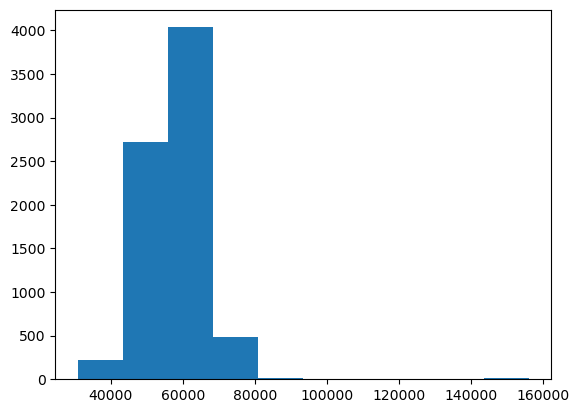

In [56]:
plt.hist(embs_nnd)

In [57]:
D, I = gpu_index_flat.search(concept_cavs.astype(np.float32), 2)

In [58]:
cavs_nnd = D[:, 1]

In [59]:
np.median(cavs_nnd)

-96.874176

(array([ 1.,  1.,  2., 42., 19.,  0.,  2.,  7.,  9.,  2.]),
 array([-664.00085449, -514.92407227, -365.84729004, -216.77052307,
         -67.69374847,   81.38302612,  230.45980835,  379.53659058,
         528.61334229,  677.69012451,  826.76690674]),
 <BarContainer object of 10 artists>)

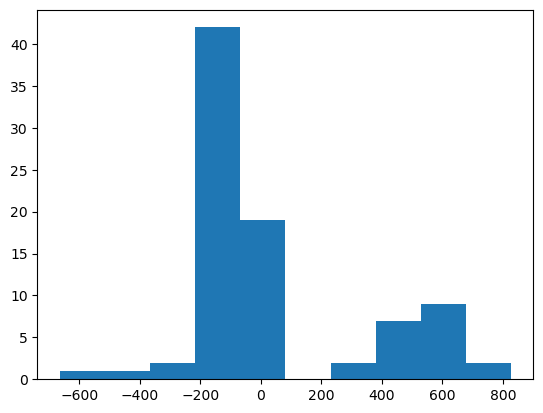

In [60]:
plt.hist(cavs_nnd)

In [78]:
embs.min(), embs.max(), concept_cavs.min(), concept_cavs.max()

(-9.72, 5.54, -0.1955047, 0.19359599)

tSNE and visualize distribution

In [63]:
joint_embs = np.concatenate([embs, concept_cavs], axis=0)

In [67]:
joint_pcas = PCA(n_components=64).fit_transform(joint_embs)

In [69]:
joint_tsnes = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3, n_jobs=-1).fit_transform(joint_pcas)

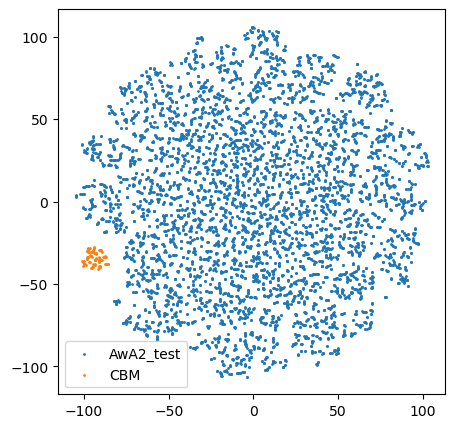

In [79]:
plt.figure(figsize=(5, 5))
plt.scatter(*joint_tsnes[:embs.shape[0]].T, label='AwA2_test', s=1)
plt.scatter(*joint_tsnes[embs.shape[0]:].T, label='CBM', s=1)
plt.legend()